<a href="https://colab.research.google.com/github/luxizh/EE62_Select_topic_for_Computer_Vision_Colab/blob/master/cgan_is_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
epoch: 1/2 step: 50 d_loss: 0.462709, g_loss: 2.600226
epoch: 1/2 step: 100 d_loss: 0.642850, g_loss: 1.734811
epoch: 1/2 step: 150 d_loss: 0.715920, g_loss: 1.495948
epoch: 1/2 step: 200 d_loss: 0.661271, g_loss: 1.644702
epoch: 1/2 step: 250 d_loss: 0.762669, g_loss: 1.542895
epoch: 1/2 step: 300 d_loss: 0.715722, g_loss: 1.747973
epoch: 1/2 step: 350 d_loss: 0.901787, g_loss: 1.470433
epoch: 1/2 step: 400 d_loss: 0.843954, g_loss: 1.401349
epoch: 1/2 step: 450 d_loss: 0.905641, g_loss: 1.153917
epoch: 1/2 step: 500 d_loss: 1.017702, g_loss: 1.095756
epoch: 1/2 step: 550 d_loss: 1.049678, g_loss: 0.967723
epoch: 1/2 step: 600 d_loss: 1.087620, g_loss: 1.054122
epoch: 1/2 step: 650 d_loss: 1.127126, g_loss: 0.927182
epoch: 1/2 step: 700 d_loss: 0.994798, g_loss: 1.251960
epoch: 1/2 step: 750 d_

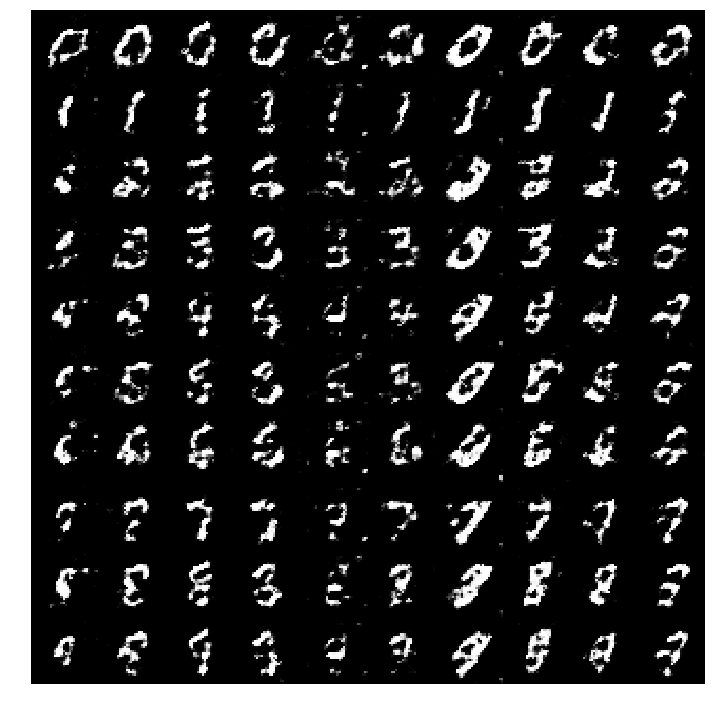

epoch: 1/2 mean d_loss: 0.880935, g_loss: 1.361875


ValueError: ignored

In [0]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
tf.reset_default_graph()


##################################################################
batch_size = 64
z_dim = 100
learning_rate_d = 0.0002
learning_rate_g = 0.0002
image_width = 32
image_height = 32
ndf = 16
ngf = 16
beta1 = 0.5
beta2 = 0.9
max_iter_step = 20000
channels = 1
log_path = './log_cgan'
ckpt_path = './ckpt_cgan'
ckpt_step_path = ckpt_path + '.step'
dataset = input_data.read_data_sets('MNIST_data', one_hot=True)
epochs=2
##################################################################


def get_batches():
    X, y = dataset.train.next_batch(batch_size)
    X = 2 * X - 1
    X = np.reshape(X, (-1, 28, 28))
    X = np.pad(X, pad_width=((0, 0), (2, 2), (2, 2)),
               mode='constant', constant_values=-1)
    X = np.expand_dims(X, -1)

    return X, y


def leaky_relu(x, leak=0.2, name='leaky_relu'):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * tf.abs(x)


def conv_cond_concat(x, y):
    x_shapes = x.get_shape()
    y_shapes = y.get_shape()

    return tf.concat([x, y * tf.ones([x_shapes[0], x_shapes[1], x_shapes[2], y_shapes[3]])], 3)


def generator(z, y, channels, training=True):
    with tf.variable_scope("generator", reuse=(not training)):
        # y_ = tf.reshape(y, shape=[batch_size, 1, 1, 10])
        z = tf.concat([z, y], axis=1)
        x = tf.layers.dense(z, 4 * 4 * ngf * 8)

        deconv1 = tf.reshape(x, (-1, 4, 4, ngf * 8))
        bn1 = tf.layers.batch_normalization(deconv1, training=training)
        relu1 = tf.nn.relu(bn1)
        # out1 = conv_cond_concat(relu1, y_)

        deconv2 = tf.layers.conv2d_transpose(
            relu1, ngf * 4, 3, strides=2, padding='SAME')
        bn2 = tf.layers.batch_normalization(deconv2, training=training)
        relu2 = tf.nn.relu(bn2)
        # out2 = conv_cond_concat(relu2, y_)

        deconv3 = tf.layers.conv2d_transpose(
            relu2, ngf * 2, 3, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(deconv3, training=training)
        relu3 = tf.nn.relu(bn3)
        # out3 = conv_cond_concat(relu3, y_)

        deconv4 = tf.layers.conv2d_transpose(
            relu3, ngf, 3, strides=2, padding='SAME')
        bn4 = tf.layers.batch_normalization(deconv4, training=training)
        relu4 = tf.nn.relu(bn4)
        # out4 = conv_cond_concat(relu4, y_)

        deconv5 = tf.layers.conv2d_transpose(
            relu4, channels, 3, strides=1, padding='SAME')
        out = tf.nn.tanh(deconv5)

        return out


def discriminator(image, y, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        y_ = tf.reshape(y, shape=(batch_size, 1, 1, 10))
        image = conv_cond_concat(image, y_)

        conv1 = tf.layers.conv2d(image, ndf, 3, strides=2, padding='SAME')
        lrelu1 = leaky_relu(conv1)
        # out1 = conv_cond_concat(lrelu1, y_)

        conv2 = tf.layers.conv2d(lrelu1, ndf * 2, 3, strides=2, padding='SAME')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = leaky_relu(bn2)
        # out2 = conv_cond_concat(lrelu2, y_)

        conv3 = tf.layers.conv2d(lrelu2, ndf * 4, 3, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = leaky_relu(bn3)
        # out3 = conv_cond_concat(lrelu3, y_)

        conv4 = tf.layers.conv2d(lrelu3, ndf * 8, 3, strides=1, padding='SAME')
        bn4 = tf.layers.batch_normalization(conv4, training=True)
        lrelu4 = leaky_relu(bn4)
        # out4 = conv_cond_concat(lrelu4, y_)

        flat = tf.reshape(lrelu4, [batch_size, -1])

        # flat = tf.concat([flat, y], axis=1)

        logits = tf.layers.dense(flat, 1)

        out = tf.sigmoid(logits)

        return out, logits


def model_inputs():
    inputs_real = tf.placeholder(tf.float32, shape=(
        batch_size, image_width, image_height, channels))
    inputs_y = tf.placeholder(tf.float32, shape=(batch_size, 10))
    inputs_z = tf.placeholder(tf.float32, shape=(batch_size, z_dim))

    return inputs_real, inputs_y, inputs_z


def model_loss(input_real, input_y, input_z):
    label_smoothing = 0.9

    g = generator(input_z, input_y, channels)
    d_real, d_logits_real = discriminator(input_real, input_y)
    d_fake, d_logits_fake = discriminator(g, input_y, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_fake) * label_smoothing))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_fake) * label_smoothing))

    return d_loss, g_loss


def model_opt(d_loss, g_loss):
    d_vars = tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
    g_vars = tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(
            learning_rate_d, beta1, beta2).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(
            learning_rate_g, beta1, beta2).minimize(g_loss, var_list=g_vars)

    return d_opt, g_opt


def main():
    input_real, input_y, input_z = model_inputs()
    d_loss, g_loss = model_loss(input_real, input_y, input_z)
    d_opt, g_opt = model_opt(d_loss, g_loss)

    d_loss_sum = tf.summary.scalar("d_loss", d_loss)
    g_loss_sum = tf.summary.scalar("g_loss", g_loss)
    merged_all = tf.summary.merge_all()

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    summary_writer = tf.summary.FileWriter(log_path, tf.get_default_graph())

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.9

    fixed_z = np.random.normal(0.0, 1.0, size=(batch_size, z_dim))

    with tf.Session(config=config) as sess:
        Epoch_D_train_losses=[]
        Epoch_G_train_losses=[]
        '''
        if os.path.isfile(ckpt_step_path):
            with open(ckpt_step_path, 'rb') as f:
                start_step = int(f.read())
            print('Training was interrupted. Continuing at step', start_step)
            saver.restore(sess, ckpt_path)
        else:
            start_step = 0
            sess.run(init)
        '''
        sess.run(init)
        step=0
        #sample_image_id = 0
        for epoch in range(epochs):
            D_train_losses=[]
            G_train_losses=[]
            for i in range(dataset.train.num_examples //batch_size):
                step+=1
                x, y = get_batches()
                z = np.random.normal(0.0, 1.0, size=(batch_size, z_dim))
                sess.run(d_opt, feed_dict={input_real: x, input_y: y, input_z: z})
                sess.run(g_opt, feed_dict={input_real: x, input_y: y, input_z: z})

                if step % 50 == 0:
                    d_loss_val, g_loss_val, merged_summary = sess.run([d_loss, g_loss, merged_all],
                                                                    feed_dict={input_real: x, input_y: y, input_z: z})
                    print('epoch: %d/%d step: %d d_loss: %f, g_loss: %f' %
                        (epoch+1, epochs, step, d_loss_val, g_loss_val))
                    summary_writer.add_summary(merged_summary, step)
                    D_train_losses.append(d_loss_val)
                    G_train_losses.append(g_loss_val)



            if (step != 0 and step % 500 == 0):
                saver.save(sess, ckpt_path)
                print('Save model at step', step)
                with open(ckpt_step_path, 'wb') as f:
                    f.write(b'%d' % (step + 1))
            
            overall = []
            g = generator(input_z, input_y, channels, training=False)
            for r in range(0, 10):
                y = np.zeros((batch_size, 10))
                y[:, r] = 1
                gen_images = g.eval(
                    feed_dict={input_z: fixed_z, input_y: y})
                temp = []
                for c in range(10):
                    temp.append(gen_images[c])
                overall.append(np.concatenate(temp, axis=1))
            res = np.concatenate(overall, axis=0)
            res = np.squeeze(res)
            plt.figure(figsize=[10, 10])
            plt.axis('off')
            res = 1 - (res + 1) / 2
            plt.imshow(res, cmap='binary')
            plt.tight_layout()
            plt.show()
            #plt.savefig('./result/%d.png' % sample_image_id, format='png', dpi=51.2)
            #print('Saving %d.png' % sample_image_id)
            plt.close('all')
            #sample_image_id += 1
            Epoch_D_train_losses.append(np.mean(D_train_losses))
            Epoch_G_train_losses.append(np.mean(G_train_losses))
            print('epoch: %d/%d mean d_loss: %f, g_loss: %f' %
                (epoch+1, epochs, np.mean(D_train_losses), np.mean(G_train_losses)))
            test_size=1000
            test_z = np.random.normal(0.0, 1.0, size=(test_size*10, z_dim))
            for r in range(0, 10):
                y = np.zeros((test_size, 10))
                test_label=np.zeros([test_size*10])
                y[r*test_size:(r+1)*test_size, r] = 1
                test_label[r*test_size:(r+1)*test_size]=r
            test_images = g.eval(
                feed_dict={input_z: test_z, input_y: y})
        #os.remove(ckpt_step_path)
        return Epoch_D_train_losses,Epoch_D_train_losses,test_images,test_label


if __name__ == '__main__':
    Epoch_D_train_losses,Epoch_D_train_losses,test_images,test_label=main()


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
epoch: 1/2 step: 50 d_loss: 0.550496, g_loss: 2.184524
epoch: 1/2 step: 100 d_loss: 0.797492, g_loss: 1.634357
epoch: 1/2 step: 150 d_loss: 0.780603, g_loss: 1.460897
epoch: 1/2 step: 200 d_loss: 0.818573, g_loss: 1.501659
epoch: 1/2 step: 250 d_loss: 0.855035, g_loss: 1.294759
epoch: 1/2 step: 300 d_loss: 1.047515, g_loss: 1.032898
epoch: 1/2 step: 350 d_loss: 0.936400, g_loss: 1.250763
epoch: 1/2 step: 400 d_loss: 1.027565, g_loss: 1.313315
epoch: 1/2 step: 450 d_loss: 1.017978, g_loss: 1.060687
epoch: 1/2 step: 500 d_loss: 1.037234, g_loss: 1.096772
epoch: 1/2 step: 550 d_loss: 1.100502, g_loss: 0.957869
epoch: 1/2 step: 600 d_loss: 1.128513, g_loss: 0.952135
epoch: 1/2 step: 650 d_loss: 1.061321, g_loss: 1.128927
epoch: 1/2 step: 700 d_loss: 1.006325, g_loss: 1.101656
epoch: 1/2 step: 750 d_

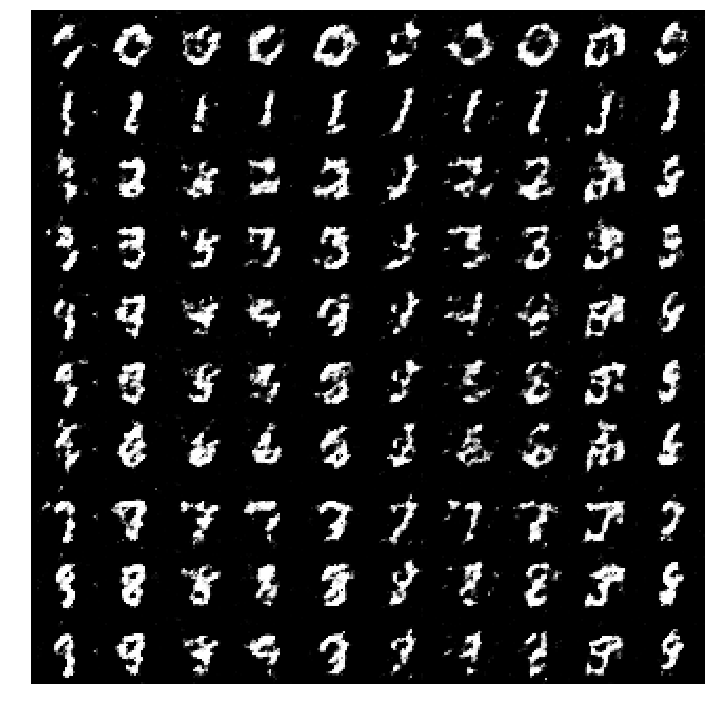

epoch: 1/2 mean d_loss: 1.262674, g_loss: 1.262674
epoch: 2/2 step: 900 d_loss: 0.934751, g_loss: 1.151353
epoch: 2/2 step: 950 d_loss: 0.888031, g_loss: 1.380734
epoch: 2/2 step: 1000 d_loss: 0.919319, g_loss: 1.094187
epoch: 2/2 step: 1050 d_loss: 0.852559, g_loss: 1.445568
epoch: 2/2 step: 1100 d_loss: 0.826344, g_loss: 1.414016
epoch: 2/2 step: 1150 d_loss: 1.029803, g_loss: 0.974064
epoch: 2/2 step: 1200 d_loss: 0.838126, g_loss: 1.362028
epoch: 2/2 step: 1250 d_loss: 1.026751, g_loss: 0.958075
epoch: 2/2 step: 1300 d_loss: 0.855276, g_loss: 1.335294
epoch: 2/2 step: 1350 d_loss: 0.810676, g_loss: 1.463106
epoch: 2/2 step: 1400 d_loss: 0.727063, g_loss: 1.666604
epoch: 2/2 step: 1450 d_loss: 0.891495, g_loss: 1.146453
epoch: 2/2 step: 1500 d_loss: 0.830303, g_loss: 1.479125
epoch: 2/2 step: 1550 d_loss: 0.810169, g_loss: 1.570019
epoch: 2/2 step: 1600 d_loss: 0.817231, g_loss: 1.373164
epoch: 2/2 step: 1650 d_loss: 0.810254, g_loss: 1.259024
epoch: 2/2 step: 1700 d_loss: 0.807611,

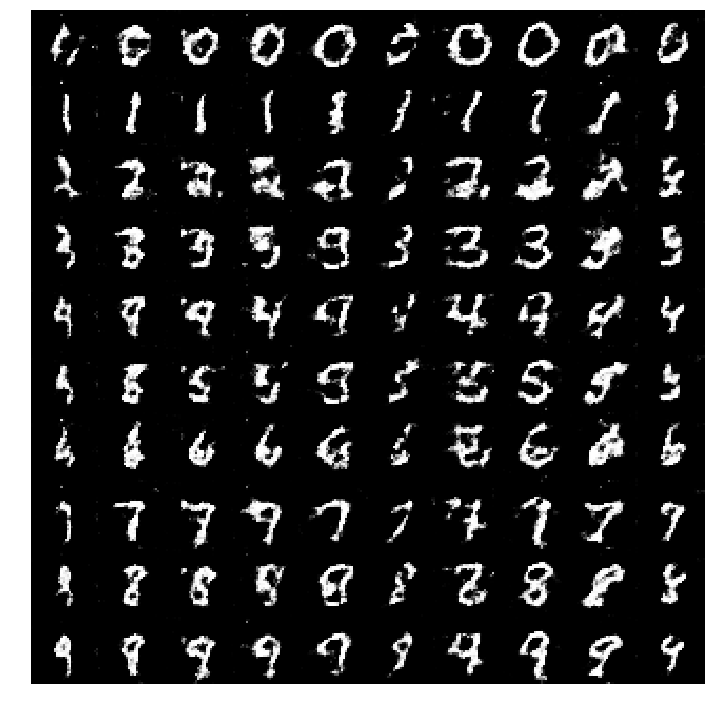

epoch: 2/2 mean d_loss: 1.333563, g_loss: 1.333563


In [0]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
tf.reset_default_graph()


##################################################################
batch_size = 64
z_dim = 100
learning_rate_d = 0.0002
learning_rate_g = 0.0002
image_width = 32
image_height = 32
ndf = 16
ngf = 16
beta1 = 0.5
beta2 = 0.9
max_iter_step = 20000
channels = 1
log_path = './log_cgan'
ckpt_path = './ckpt_cgan'
ckpt_step_path = ckpt_path + '.step'
dataset = input_data.read_data_sets('MNIST_data', one_hot=True)
epochs=2
##################################################################


def get_batches():
    X, y = dataset.train.next_batch(batch_size)
    X = 2 * X - 1
    X = np.reshape(X, (-1, 28, 28))
    X = np.pad(X, pad_width=((0, 0), (2, 2), (2, 2)),
               mode='constant', constant_values=-1)
    X = np.expand_dims(X, -1)

    return X, y


def leaky_relu(x, leak=0.2, name='leaky_relu'):
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * tf.abs(x)


def conv_cond_concat(x, y):
    x_shapes = x.get_shape()
    y_shapes = y.get_shape()

    return tf.concat([x, y * tf.ones([x_shapes[0], x_shapes[1], x_shapes[2], y_shapes[3]])], 3)


def generator(z, y, channels, training=True):
    with tf.variable_scope("generator", reuse=(not training)):
        # y_ = tf.reshape(y, shape=[batch_size, 1, 1, 10])
        z = tf.concat([z, y], axis=1)
        x = tf.layers.dense(z, 4 * 4 * ngf * 8)

        deconv1 = tf.reshape(x, (-1, 4, 4, ngf * 8))
        bn1 = tf.layers.batch_normalization(deconv1, training=training)
        relu1 = tf.nn.relu(bn1)
        # out1 = conv_cond_concat(relu1, y_)

        deconv2 = tf.layers.conv2d_transpose(
            relu1, ngf * 4, 3, strides=2, padding='SAME')
        bn2 = tf.layers.batch_normalization(deconv2, training=training)
        relu2 = tf.nn.relu(bn2)
        # out2 = conv_cond_concat(relu2, y_)

        deconv3 = tf.layers.conv2d_transpose(
            relu2, ngf * 2, 3, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(deconv3, training=training)
        relu3 = tf.nn.relu(bn3)
        # out3 = conv_cond_concat(relu3, y_)

        deconv4 = tf.layers.conv2d_transpose(
            relu3, ngf, 3, strides=2, padding='SAME')
        bn4 = tf.layers.batch_normalization(deconv4, training=training)
        relu4 = tf.nn.relu(bn4)
        # out4 = conv_cond_concat(relu4, y_)

        deconv5 = tf.layers.conv2d_transpose(
            relu4, channels, 3, strides=1, padding='SAME')
        out = tf.nn.tanh(deconv5)

        return out


def discriminator(image, y, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        y_ = tf.reshape(y, shape=(batch_size, 1, 1, 10))
        image = conv_cond_concat(image, y_)

        conv1 = tf.layers.conv2d(image, ndf, 3, strides=2, padding='SAME')
        lrelu1 = leaky_relu(conv1)
        # out1 = conv_cond_concat(lrelu1, y_)

        conv2 = tf.layers.conv2d(lrelu1, ndf * 2, 3, strides=2, padding='SAME')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        lrelu2 = leaky_relu(bn2)
        # out2 = conv_cond_concat(lrelu2, y_)

        conv3 = tf.layers.conv2d(lrelu2, ndf * 4, 3, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        lrelu3 = leaky_relu(bn3)
        # out3 = conv_cond_concat(lrelu3, y_)

        conv4 = tf.layers.conv2d(lrelu3, ndf * 8, 3, strides=1, padding='SAME')
        bn4 = tf.layers.batch_normalization(conv4, training=True)
        lrelu4 = leaky_relu(bn4)
        # out4 = conv_cond_concat(lrelu4, y_)

        flat = tf.reshape(lrelu4, [batch_size, -1])

        # flat = tf.concat([flat, y], axis=1)

        logits = tf.layers.dense(flat, 1)

        out = tf.sigmoid(logits)

        return out, logits


def model_inputs():
    inputs_real = tf.placeholder(tf.float32, shape=(
        batch_size, image_width, image_height, channels))
    inputs_y = tf.placeholder(tf.float32, shape=(batch_size, 10))
    inputs_z = tf.placeholder(tf.float32, shape=(batch_size, z_dim))

    return inputs_real, inputs_y, inputs_z


def model_loss(input_real, input_y, input_z):
    label_smoothing = 0.9

    g = generator(input_z, input_y, channels)
    d_real, d_logits_real = discriminator(input_real, input_y)
    d_fake, d_logits_fake = discriminator(g, input_y, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels=tf.ones_like(d_real) * label_smoothing))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_fake) * label_smoothing))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_fake) * label_smoothing))

    return d_loss, g_loss


def model_opt(d_loss, g_loss):
    d_vars = tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
    g_vars = tf.get_collection(
        tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(
            learning_rate_d, beta1, beta2).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(
            learning_rate_g, beta1, beta2).minimize(g_loss, var_list=g_vars)

    return d_opt, g_opt


def main():
    input_real, input_y, input_z = model_inputs()
    d_loss, g_loss = model_loss(input_real, input_y, input_z)
    d_opt, g_opt = model_opt(d_loss, g_loss)

    d_loss_sum = tf.summary.scalar("d_loss", d_loss)
    g_loss_sum = tf.summary.scalar("g_loss", g_loss)
    merged_all = tf.summary.merge_all()

    init = tf.global_variables_initializer()
    saver = tf.train.Saver()
    summary_writer = tf.summary.FileWriter(log_path, tf.get_default_graph())

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.9

    fixed_z = np.random.normal(0.0, 1.0, size=(batch_size, z_dim))

    with tf.Session(config=config) as sess:
        Epoch_D_train_losses=[]
        Epoch_G_train_losses=[]
        '''
        if os.path.isfile(ckpt_step_path):
            with open(ckpt_step_path, 'rb') as f:
                start_step = int(f.read())
            print('Training was interrupted. Continuing at step', start_step)
            saver.restore(sess, ckpt_path)
        else:
            start_step = 0
            sess.run(init)
        '''
        sess.run(init)
        step=0
        #sample_image_id = 0
        for epoch in range(epochs):
            D_train_losses=[]
            G_train_losses=[]
            for i in range(dataset.train.num_examples //batch_size):
                step+=1
                x, y = get_batches()
                z = np.random.normal(0.0, 1.0, size=(batch_size, z_dim))
                sess.run(d_opt, feed_dict={input_real: x, input_y: y, input_z: z})
                sess.run(g_opt, feed_dict={input_real: x, input_y: y, input_z: z})

                if step % 50 == 0:
                    d_loss_val, g_loss_val, merged_summary = sess.run([d_loss, g_loss, merged_all],
                                                                    feed_dict={input_real: x, input_y: y, input_z: z})
                    print('epoch: %d/%d step: %d d_loss: %f, g_loss: %f' %
                        (epoch+1, epochs, step, d_loss_val, g_loss_val))
                    summary_writer.add_summary(merged_summary, step)
                    D_train_losses.append(d_loss_val)
                    G_train_losses.append(g_loss_val)



            if (step != 0 and step % 500 == 0):
                saver.save(sess, ckpt_path)
                print('Save model at step', step)
                with open(ckpt_step_path, 'wb') as f:
                    f.write(b'%d' % (step + 1))
            
            overall = []
            g = generator(input_z, input_y, channels, training=False)
            for r in range(0, 10):
                y = np.zeros((batch_size, 10))
                y[:, r] = 1
                gen_images = g.eval(
                    feed_dict={input_z: fixed_z, input_y: y})
                temp = []
                for c in range(10):
                    temp.append(gen_images[c])
                overall.append(np.concatenate(temp, axis=1))
            res = np.concatenate(overall, axis=0)
            res = np.squeeze(res)
            plt.figure(figsize=[10, 10])
            plt.axis('off')
            res = 1 - (res + 1) / 2
            plt.imshow(res, cmap='binary')
            plt.tight_layout()
            plt.show()
            #plt.savefig('./result/%d.png' % sample_image_id, format='png', dpi=51.2)
            #print('Saving %d.png' % sample_image_id)
            plt.close('all')
            #sample_image_id += 1
            Epoch_D_train_losses.append(np.mean(D_train_losses))
            Epoch_G_train_losses.append(np.mean(G_train_losses))
            print('epoch: %d/%d mean d_loss: %f, g_loss: %f' %
                (epoch+1, epochs, np.mean(D_train_losses), np.mean(G_train_losses)))
        #os.remove(ckpt_step_path)
        return Epoch_D_train_losses,Epoch_D_train_losses


if __name__ == '__main__':
    Epoch_D_train_losses,Epoch_D_train_losses=main()


In [0]:
x = np.linspace(1, epochs, epochs)
fig = plt.figure()
plt.plot(x, Epoch_D_train_losses,label='D_loss' )
plt.plot(x, Epoch_G_train_losses, label='G_loss' )
plt.xlabel('Epoch')
plt.legend(loc=1)
plt.ylabel('Loss')
print(Epoch_D_train_losses)
print(Epoch_G_train_losses)

NameError: ignored

<Figure size 576x396 with 0 Axes>

In [0]:
import pickle
print(Epoch_D_train_losses)
print(Epoch_G_train_losses)
filename = 'Dloss.data'
f = open(filename, 'wb')
pickle.dump(Epoch_D_train_losses,f)
f.close()
filename = 'Gloss.data'
f = open(filename, 'wb')
pickle.dump(Epoch_G_train_losses,f)
f.close()
from google.colab import files
files.download('Dloss.data')
files.download('Gloss.data')